# STATS 201 – Course Project

## Predicting Population Decline Using Migration and Demographic Data


## 1. Imports and Environment Setup

In this section, we import the required Python libraries and configure basic display settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Display settings for better readability
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

## 2. Loading the Dataset

The dataset contains population and migration data for 186 countries over multiple decades.  
We load the CSV file and inspect its basic structure.

In [2]:
# Load dataset from local directory
df_raw = pd.read_csv("world_pop_mig_186_countries.csv")

# Inspect dataset shape and first few rows
df_raw.shape

(11904, 5)

## 3. Data Cleaning and Structure

We standardize column names, identify key variables, and ensure the data are sorted correctly for time-series analysis.

In [3]:
# Standardize column names
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Identify country and year columns
country_col = next((c for c in df.columns if "country" in c), None)
year_col = "year"

# Convert year to numeric and sort data
df[year_col] = pd.to_numeric(df[year_col], errors="coerce")
df = df.dropna(subset=[year_col])
df[year_col] = df[year_col].astype(int)

df = df.sort_values([country_col, year_col]).reset_index(drop=True)

(df.head(), df[country_col].nunique(), df[year_col].min(), df[year_col].max())

(       country  year  population  netmigration  population_in_millions
 0  Afghanistan  1960   8622466.0        2606.0                       8
 1  Afghanistan  1961   8790140.0        6109.0                       8
 2  Afghanistan  1962   8969047.0        7016.0                       8
 3  Afghanistan  1963   9157465.0        6681.0                       9
 4  Afghanistan  1964   9355514.0        7079.0                       9,
 186,
 1960,
 2023)

## 4. Key Variables

We identify numeric variables related to population and migration that will later be used as predictors in the machine learning models.

In [4]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Identify population and migration-related variables
pop_candidates = [c for c in numeric_cols if "pop" in c]
mig_candidates = [c for c in numeric_cols if "mig" in c or "migration" in c]

pop_candidates, mig_candidates

(['population', 'population_in_millions'], ['netmigration'])

## 5. Derived Variables

We create simple derived variables such as population growth rate and lagged migration values to support exploratory analysis.

In [5]:
POP_COL = pop_candidates[0]
MIG_COL = mig_candidates[0]

# Lagged population
df["pop_lag1"] = df.groupby(country_col)[POP_COL].shift(1)

# Population growth rate
df["pop_growth_rate"] = (df[POP_COL] - df["pop_lag1"]) / df["pop_lag1"]

# Lagged migration
df["mig_lag1"] = df.groupby(country_col)[MIG_COL].shift(1)

# Log population for scale normalization
df["log_pop"] = np.log(df[POP_COL].replace({0: np.nan}))

df[[country_col, year_col, POP_COL, MIG_COL, "pop_growth_rate"]].head()

,country,year,population,netmigration,pop_growth_rate
0,Afghanistan,1960,8622466.0,2606.0,NaN
1,Afghanistan,1961,8790140.0,6109.0,0.019446
2,Afghanistan,1962,8969047.0,7016.0,0.020353
3,Afghanistan,1963,9157465.0,6681.0,0.021008
4,Afghanistan,1964,9355514.0,7079.0,0.021627


## 6. Initial Exploratory Analysis

This section explores global trends in population growth and migration over time, as well as their relationship.

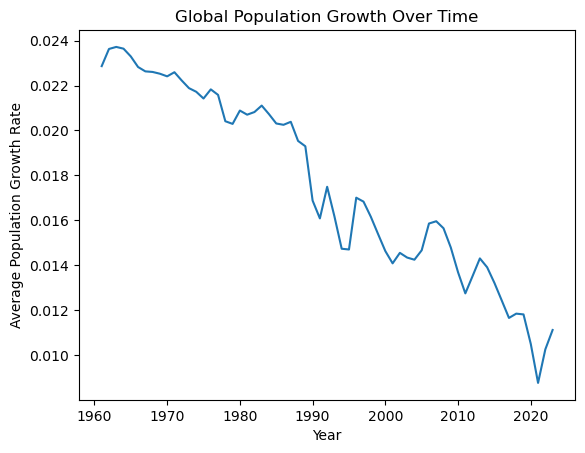

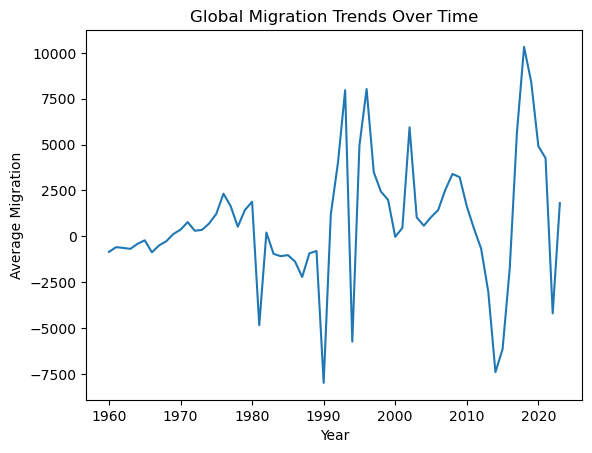

In [6]:
# Global average population growth over time
growth_time = df.groupby(year_col)["pop_growth_rate"].mean().reset_index()

plt.figure()
plt.plot(growth_time[year_col], growth_time["pop_growth_rate"])
plt.xlabel("Year")
plt.ylabel("Average Population Growth Rate")
plt.title("Global Population Growth Over Time")
plt.show()

# Global average migration over time
mig_time = df.groupby(year_col)[MIG_COL].mean().reset_index()

plt.figure()
plt.plot(mig_time[year_col], mig_time[MIG_COL])
plt.xlabel("Year")
plt.ylabel("Average Migration")
plt.title("Global Migration Trends Over Time")
plt.show()

## 7. Migration and Population Growth Relationship

We examine the relationship between migration and population growth across all country–year observations.

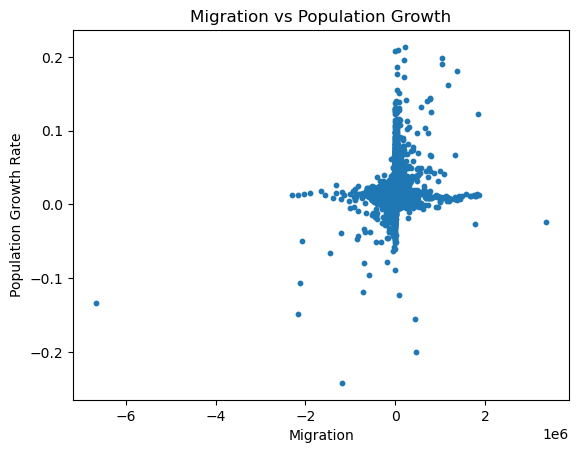

In [15]:
plot_df = df.dropna(subset=["pop_growth_rate", MIG_COL])

plt.figure()
plt.scatter(plot_df[MIG_COL], plot_df["pop_growth_rate"], s=10)
plt.xlabel("Migration")
plt.ylabel("Population Growth Rate")
plt.title("Migration vs Population Growth")
plt.show()

## 7. Country-Level Time Series Exploration

To better understand heterogeneity across countries, we visualize population and migration trends over time for a small subset of countries with the most complete data.  
These plots help illustrate how demographic and migration dynamics vary across countries and motivate the use of pooled machine learning models rather than country-specific models.

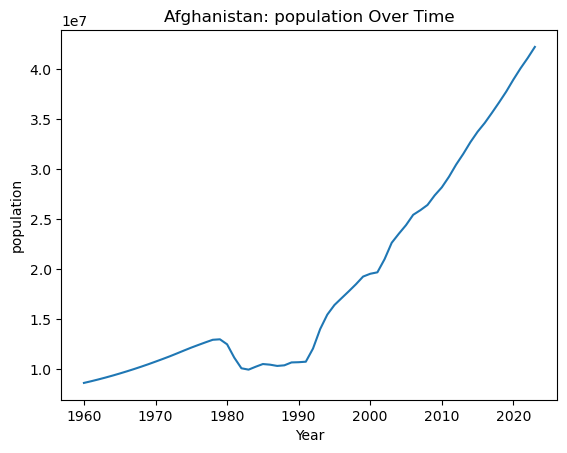

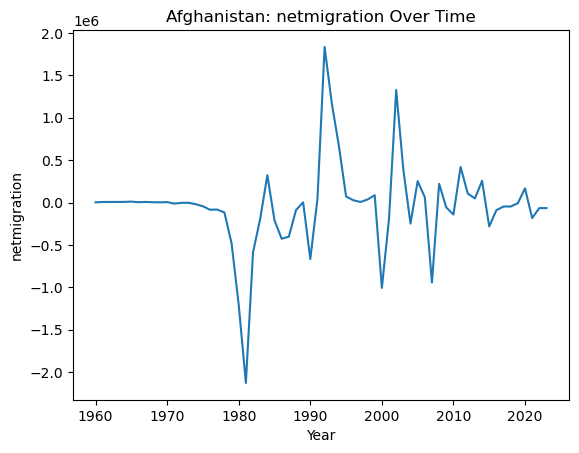

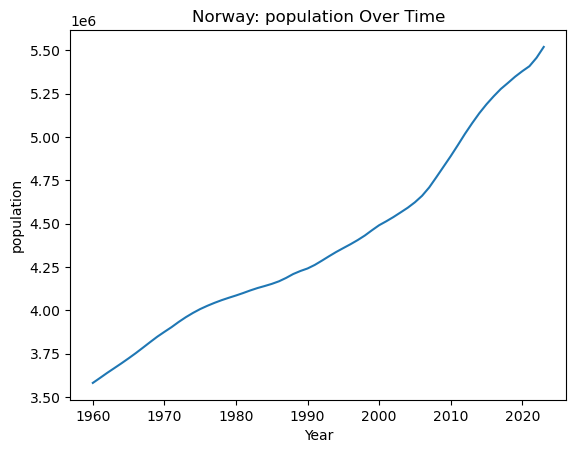

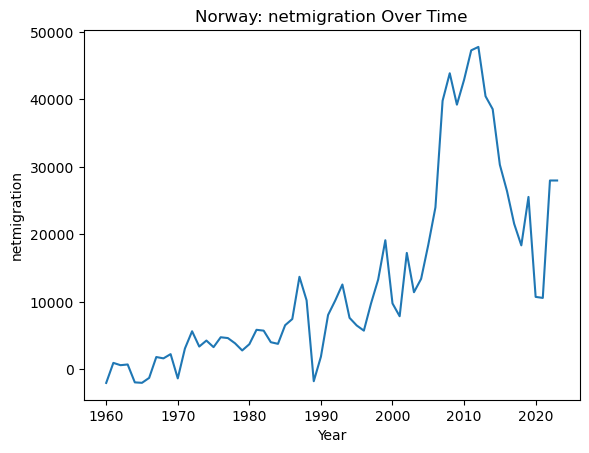

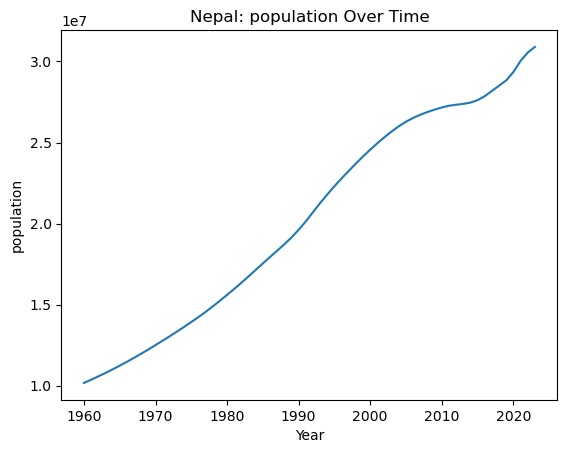

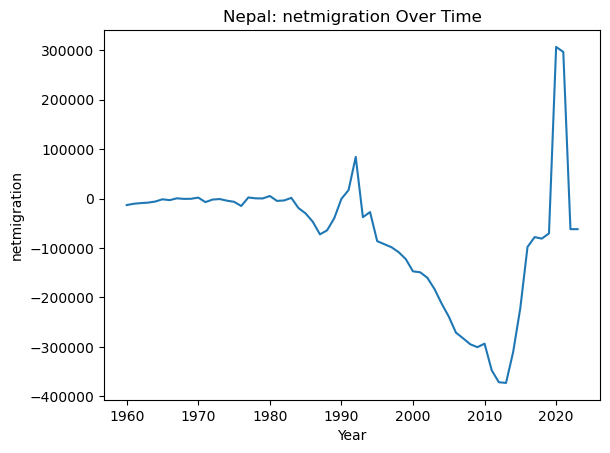

In [16]:
# Select a small subset of countries for visualization
# We use countries with the highest number of observations to ensure complete time series
top_countries = df[country_col].value_counts().head(3).index.tolist()

# Plot population and migration trends over time for selected countries
for c in top_countries:
    
    # Subset data for a single country and sort by year
    d = df[df[country_col] == c].sort_values(year_col)
    
    # Plot population over time
    plt.figure()
    plt.plot(d[year_col], d[POP_COL])
    plt.title(f"{c}: {POP_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(POP_COL)
    plt.show()
    
    # Plot migration over time
    plt.figure()
    plt.plot(d[year_col], d[MIG_COL])
    plt.title(f"{c}: {MIG_COL} Over Time")
    plt.xlabel("Year")
    plt.ylabel(MIG_COL)
    plt.show()